In [13]:
import os,sys
import h5py as h5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
#import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

def make_histo(dic):
    
    station = dic['station']

    fs = 12
    plt.title('Private/Restricted records for ' + station, fontsize = fs)
    
    tot_res = len(dic['private'])
    tot_free = len(dic['free'])
    tot = tot_res + tot_free 
    perc_res = int( tot_res/ tot * 100 )
    perc_free = int( tot_free/ tot * 100 )

    
    plt.hist([dic['free'],dic['private']],
              histtype = 'stepfilled',
              color = ['blue','orange'],
              bins = 50,
              stacked = True,
              label = ['Free '+ str(tot_free) + '/ ' + str(perc_free) + '%'  ,
                       
                       'Restricted ' + str(tot_res) + '/ ' + str(perc_res) + '%'] )

    plt.grid(ls=':' , color='lightgray')

    plt.legend(fontsize = fs-2, loc = 'upper left')
    if not os.path.isdir('Plots'):
        os.mkdir('Plots')
        
    if not os.path.isdir('Plots/policy/'):
        os.mkdir('Plots/policy/')

    plt.tight_layout()
    plt.savefig('Plots/policy/policy_histo_' + station + '.png',
                dpi = 150 )
    
    plt.show()
    plt.close()

    
def make_geo_scatter(res):
    
    fs = 15
    
    lat_all, lon_all = [], []
    stations = []
    free, free_perc, private = [],[],[]
    
    for r in res:
        if r["lat"]:
            lat_all.append(r["lat"])
            lon_all.append(r["lon"])
            #station.append(r["station"])

            free.append(len(r["free"]) )
            private.append( len(r["private"]) )
            try:
                free_perc.append(  len(r["free"])  /  ( len(r["free"]) + len(r["private"]) )  * 100  )
            except:
                free_perc.append(100)
        else:
            print('No lat')
    
    def do_scatter(lat,lon, data, what):
        """ Creating a geo-scatter with the number of records or percentage """
        if what == "free":
            lab = "Public Records"
            cb = "viridis"
            
        elif what == "private":
            lab = "Private Records"
            cb = "viridis"

        elif what == "free_perc":
            lab = "% Free Records"
            cb = "magma"


        
        fig = plt.figure(figsize = (12,8))
        ax = plt.axes(projection=ccrs.PlateCarree() )
        ax.coastlines()

        """
        #clb=f.colorbar(c,ax=ax,orientation='horizontal')                                                                                                                                                                                                                                     
        #clb.ax.set_title('{:6.4f}'.format(np.mean(ds[k]).values/43200)+' '+units)                                                                                                                                                                                                            
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        world = world.plot()
        WMO.plot( ax=world,  facecolor="none", edgecolor="lightgray", lw = 0.8)
        """
        
        plt.xlim([-180.,180.])
        plt.ylim([-90.,90.])

        #print(lon, lat )
        plt.scatter( lon, lat , c= data, cmap=cb , transform=ccrs.PlateCarree() )
        cbar = plt.colorbar(fraction=0.03, pad=0.03) # pad moves bar to left-right, fractions is the length of the bar
        cbar.set_label(lab, fontsize = fs)

        plt.title ('Data Policy - Records' , fontsize = fs)

        plt.savefig("Plots/policy/geo-scatter_" + what + '.png', dpi= 250,   bbox_inches = 'tight' )
        plt.show()

    do_scatter(lat_all, lon_all, free,"free")
    do_scatter(lat_all, lon_all, private,"private")
    do_scatter(lat_all, lon_all, free_perc,"free_perc")

    
def get_data(file):
    
    dic = {'free':[],
           'private':[],
           'lat': '',
           'lon': '',
           'station': '' }

    
    try:
        station = file.split('-0-')[1].split('_CEUAS')[0]
        dic['station'] = station
        
        F = h5.File(file)

        indices = np.array(F['recordindex'][:])
        dates = np.array(F['recordtimestamp'][:])

        policy = np.array(F['observations_table']['data_policy_licence'][:])
        policy = policy[indices]

        private = np.where(policy == 4 )[0]
        free = np.where(policy == 0)[0]

        free_dates = 1900 + (dates[free]/ (365.25*60*60*24) )
        private_dates = 1900 + dates[private] / (365.25*60*60*24) 

        dic['free'] = free_dates
        dic['private'] = private_dates
        dic['lat'] = F['observations_table']['latitude'][0]
        dic['lon'] = F['observations_table']['longitude'][0]

    except:
        print('FAIL: ' , file )
        
    try:
        F = h5.File(file)
        h = F['header_table']['report_timestamp'][0]
    except:
        print('Failed HEADER')
    return dic
    
     

    

In [2]:
'''
f1 = '/raid60/scratch/federico/MERGED_26MAY2021/0-20000-0-17281_CEUAS_merged_v1.nc'
dic = get_data(f1, station = '17281')
dummy_plot = make_histo(dic, station= '17281')
'''

"\nf1 = '/raid60/scratch/federico/MERGED_26MAY2021/0-20000-0-17281_CEUAS_merged_v1.nc'\ndic = get_data(f1, station = '17281')\ndummy_plot = make_histo(dic, station= '17281')\n"

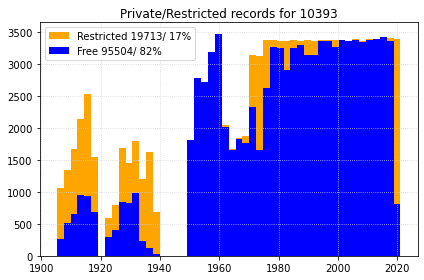

In [3]:
f = '/raid60/scratch/federico/MERGED_26MAY2021/0-20001-0-10393_CEUAS_merged_v1.nc'
dic = get_data(f)
dummy_plot = make_histo(dic)

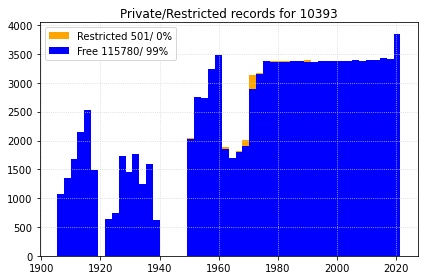

In [4]:
f = '/raid60/scratch/federico/MERGED_JUNE2021/0-20001-0-10393_CEUAS_merged_v1.nc'
dic = get_data(f)
dummy_plot = make_histo(dic)

In [5]:
#f = '/raid60/scratch/federico/MERGED_26MAY2021/0-20000-0-82930_CEUAS_merged_v1.nc'
#dic = get_data(f)
#dummy_plot = make_histo(dic)

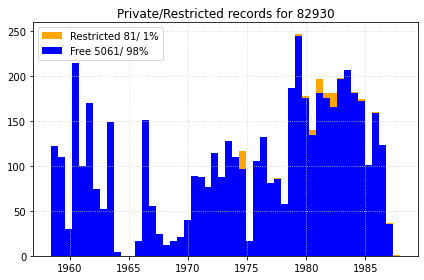

In [6]:
f = '/raid60/scratch/federico/MERGED_JUNE2021/0-20000-0-82930_CEUAS_merged_v1.nc'
dic = get_data(f)
dummy_plot = make_histo(dic)


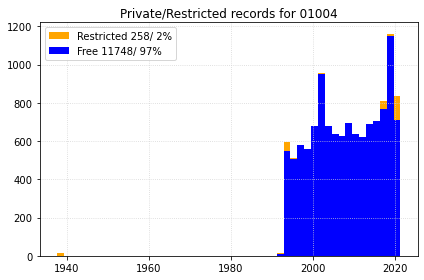

In [7]:
f = '/raid60/scratch/federico/MERGED_JUNE2021/0-20001-0-01004_CEUAS_merged_v1.nc'
dic = get_data(f)
dummy_plot = make_histo(dic)

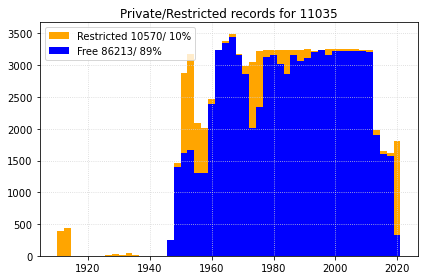

In [8]:
f = '/raid60/scratch/federico/MERGED_26MAY2021/0-20001-0-11035_CEUAS_merged_v1.nc'
dic = get_data(f)
dummy_plot = make_histo(dic)

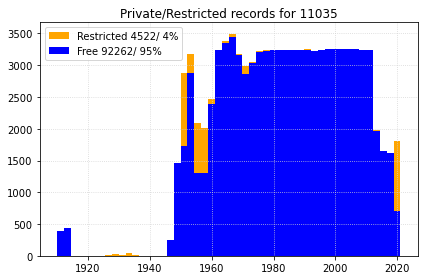

In [9]:
f = '/raid60/scratch/federico/MERGED_JUNE2021/0-20001-0-11035_CEUAS_merged_v1.nc'
dic = get_data(f)
dummy_plot = make_histo(dic)

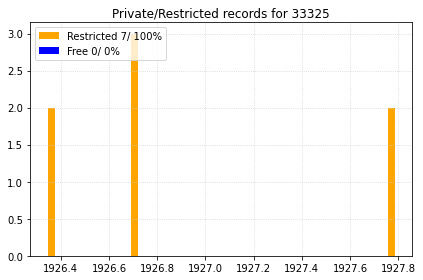

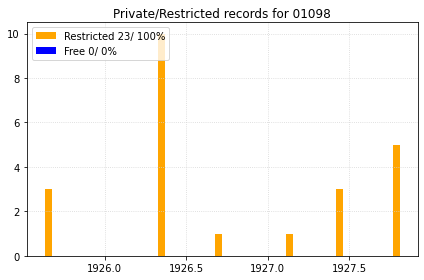

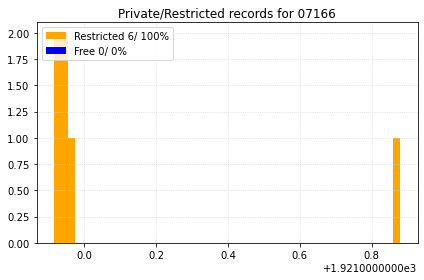

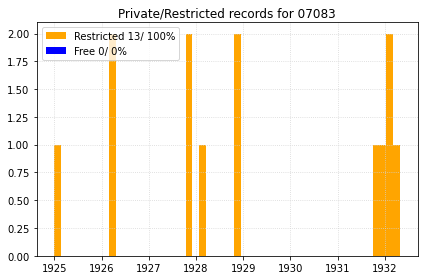

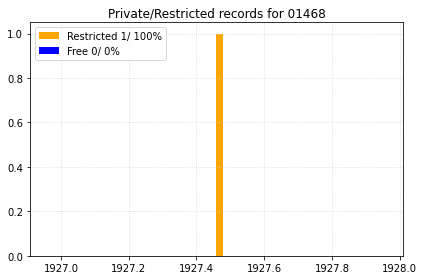

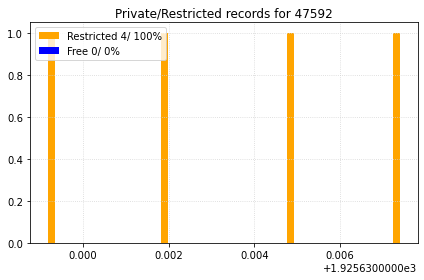

In [10]:
for s in ['33325' , '01098', '07166','07083','01468','47592']:
    f = '/raid60/scratch/federico/MERGED_26MAY2021/0-20000-0-XXXXX_CEUAS_merged_v1.nc'
    f = f.replace('XXXXX',s)
    dic = get_data(f)
    dummy_plot = make_histo(dic)


In [11]:
func = partial(get_data)
p = Pool(30)
m_dir = '/raid60/scratch/federico/MERGED_JUNE2021/'
files = [m_dir+'/'+f for f in os.listdir(m_dir) if '_beforeSensor' not in f and '.nc' in f]

#files = files[4000:4500]
res=list(p.map(func, files))
    
res_all = {'free': [] , 'private': [] , 'station': ' all merged records'}

for r in res:
    res_all['free'].extend(r['free'])
    res_all['private'].extend(r['private'])
    

FAIL:  /raid60/scratch/federico/MERGED_JUNE2021//0-20000-2-29842_CEUAS_merged_v1.nc


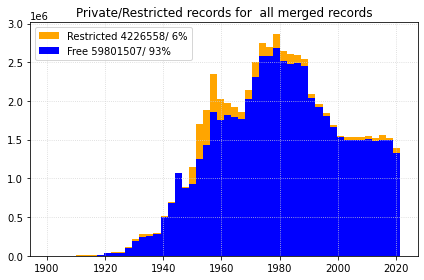

No lat
No lat
No lat


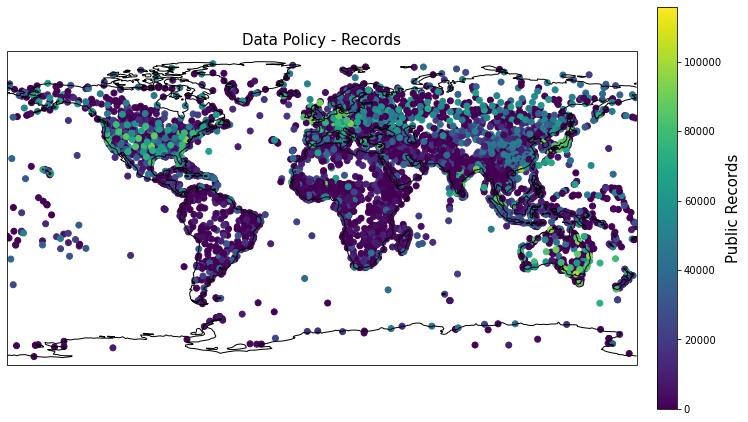

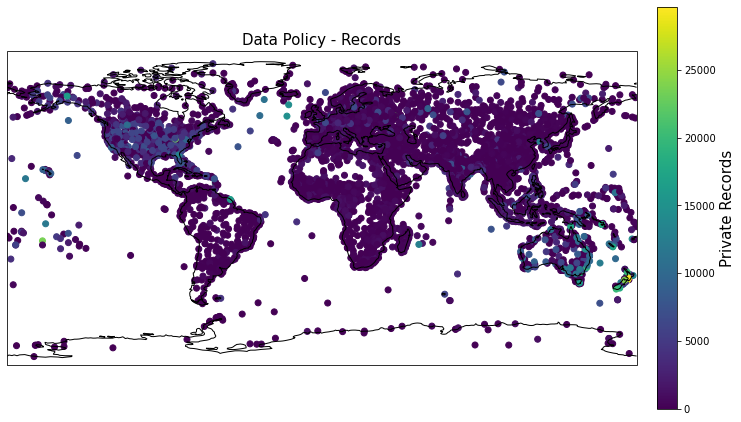

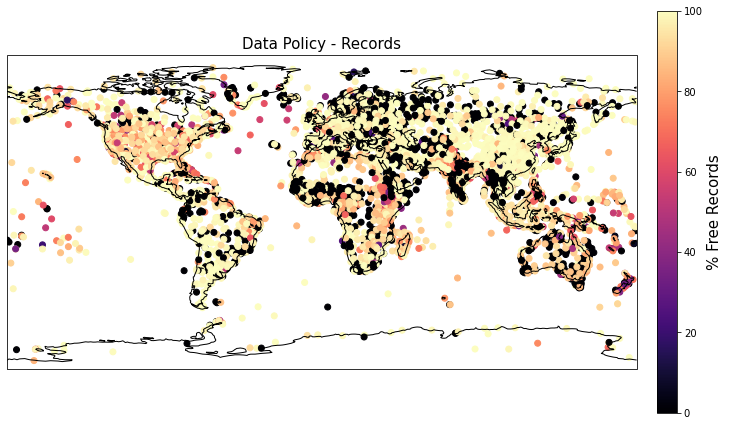

In [14]:
dummy_plot = make_histo(res_all)
dummy_plot = make_geo_scatter(res)
    